# analysis across groups for VSD dataset
where groups = model mode, training method, and neural network architecture

uses "summary data" csvs saved by `searchnets.assay`

In [1]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns
import scipy.stats
import sklearn.metrics
from sklearn.preprocessing import KBinsDiscretizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import searchnets
from searchnets import nets
from searchnets.datasets import VOCDetection
from searchnets.engine.abstract_trainer import AbstractTrainer
from searchnets.transforms.util import get_transforms
from searchnets.transforms.functional import tile
from searchnets.utils.general import make_save_path

In [2]:
VSD_RESULTS_ROOT = pyprojroot.here().joinpath('results/VSD')

VSD_TEST_RESULTS_ROOT = VSD_RESULTS_ROOT.joinpath('test_results')

### group analysis
get all the summary results csvs from each model / net / mode / method, concatenate

In [3]:
assay_results_csvs = sorted(VSD_TEST_RESULTS_ROOT.glob('**/*assay_results.csv'))

In [4]:
assay_results_df = pd.concat(
    [pd.read_csv(assay_results_csv) for assay_results_csv in assay_results_csvs]
)

COLUMNS = [
    'net_name',
    'replicate',
    'mode',
    'method',
    'loss_func',    
    'acc', 
    'd_prime',
    'restore_path'
]

assay_results_df = assay_results_df[COLUMNS]

In [5]:
assay_results_df.head()

,net_name,replicate,mode,method,loss_func,acc,d_prime,restore_path
0,CORnet_S,1,classify,initialize,BCE,0.921793,0.759977,/home/bart/Documents/repos/L2M/visual-search-n...
1,CORnet_S,2,classify,initialize,BCE,0.922313,0.517532,/home/bart/Documents/repos/L2M/visual-search-n...
2,CORnet_S,3,classify,initialize,BCE,0.922139,0.491005,/home/bart/Documents/repos/L2M/visual-search-n...
3,CORnet_S,4,classify,initialize,BCE,0.922243,0.555016,/home/bart/Documents/repos/L2M/visual-search-n...
4,CORnet_S,5,classify,initialize,BCE,0.920978,0.770735,/home/bart/Documents/repos/L2M/visual-search-n...


In [6]:
assay_group_df = assay_results_df.groupby(['net_name', 'mode', 'method', 'loss_func', ]).agg(
    mean_acc=pd.NamedAgg(column='acc', aggfunc='mean'),
    mean_dprime=pd.NamedAgg(column='d_prime', aggfunc='mean'),
)

In [7]:
assay_group_df.T

net_name      CORnet_S                                                       \
mode          classify                                               detect   
method      initialize             transfer                      initialize   
loss_func          BCE CE-largest       BCE CE-largest CE-random        BCE   
mean_acc      0.921602   0.927856  0.925459   0.957429  0.955721   0.687652   
mean_dprime   0.677890   1.597688  1.207668   2.507412  2.441572   0.725425   

net_name                CORnet_Z                       ...     VGG16  \
mode                    classify                       ...  classify   
method       transfer initialize             transfer  ...  transfer   
loss_func         BCE        BCE CE-largest       BCE  ... CE-random   
mean_acc     0.697404   0.905379   0.926734  0.933673  ...  0.961538   
mean_dprime  0.765733   0.557145   1.567468  1.671754  ...  2.682797   

net_name                            alexnet                                  \
mode            detect             classify                                   
method      initialize  transfer initialize             transfer              
loss_func          BCE       BCE        BCE CE-largest       BCE CE-largest   
mean_acc      0.730539  0.726983   0.883278   0.919968  0.951142   0.947092   
mean_dprime   0.745003  0.792601   0.199183   1.386214  2.281228   2.145544   

net_name                                    
mode                      detect            
method                initialize  transfer  
loss_func   CE-random        BCE       BCE  
mean_acc     0.948141   0.705576  0.703587  
mean_dprime  2.178818   0.742105  0.759234  

[2 rows x 28 columns]

### plots

In [ ]:
len(assay_results_df)


In [27]:
out_softmax_true = []

for ind, row in enumerate(arrays['y_true_onehot']):
    out_softmax_true.append(
        arrays['out_softmax'][ind, :][row.astype(bool)]
    )

out_softmax_true_mean = np.asarray(
    [np.mean(row) for row in out_softmax_true]
)

out_softmax_true_median = np.asarray(
    [np.median(row) for row in out_softmax_true]
)

In [62]:
test_df['acc_sig'] = (test_df['TP_sig'] + test_df['TN_sig']) / (test_df['TP_sig'] + test_df['TN_sig'] + test_df['FP_sig'] + test_df['FN_sig'])
test_df['acc_softmax'] = (test_df['TP_softmax'] + test_df['TN_softmax']) / (test_df['TP_softmax'] + test_df['TN_softmax'] + test_df['FP_softmax'] + test_df['FN_softmax'])
test_df['err_sig'] = 1 - test_df['acc_sig']
test_df['err_softmax'] = 1 - test_df['acc_softmax']

In [40]:
def acc_sig_df(df):
    return (df['TP_sig'].sum() + df['TN_sig'].sum()) / (df['TP_sig'].sum() + df['TN_sig'].sum() + df['FP_sig'].sum() + df['FN_sig'].sum())

In [41]:
def acc_softmax_df(df):
    return (df['TP_softmax'].sum() + df['TN_softmax'].sum()) / (df['TP_softmax'].sum() + df['TN_softmax'].sum() + df['FP_softmax'].sum() + df['FN_softmax'].sum())

In [42]:
def acc_by_n_item(df, max_n_item=4):
    records = defaultdict(list)
    for n_item in range(1, max_n_item + 1):
        records['n_item'].append(n_item)
        df_test_item_n = df[df['n_items'] == n_item]
        records['acc_sig'].append(acc_sig_df(df_test_item_n))
        records['acc_softmax'].append(acc_softmax_df(df_test_item_n))
        records['mean_vsd_score'].append(df_test_item_n['vsd_score'].mean())
        records['median_vsd_score'].append(df_test_item_n['vsd_score'].median())
    return pd.DataFrame.from_records(records)

In [43]:
dfs = []

for loss_func in test_df['loss_func'].unique():
    df_this_loss_func = test_df[test_df['loss_func'] == loss_func]
    df_acc_by_n_item_this_loss_func = acc_by_n_item(df_this_loss_func)
    df_acc_by_n_item_this_loss_func['loss_func'] = loss_func
    dfs.append(df_acc_by_n_item_this_loss_func)
df_acc_by_n_item = pd.concat(dfs)

In [44]:
df_acc_by_n_item

,acc_sig,acc_softmax,mean_vsd_score,median_vsd_score,n_item,loss_func
0,0.968646,0.969323,3.168365,3.118631,1,BCE
1,0.937112,0.933607,3.443818,3.298614,2,BCE
2,0.903517,0.889727,3.577412,3.430000,3,BCE
3,0.881798,0.846053,3.718485,3.500000,4,BCE
0,0.591668,0.972226,3.168365,3.118631,1,CE-largest
1,0.637318,0.927296,3.443818,3.298614,2,CE-largest
2,0.675481,0.882844,3.577412,3.430000,3,CE-largest
3,0.726425,0.837061,3.718485,3.500000,4,CE-largest
0,0.578982,0.971309,3.168365,3.118631,1,CE-random
1,0.618111,0.931265,3.443818,3.298614,2,CE-random


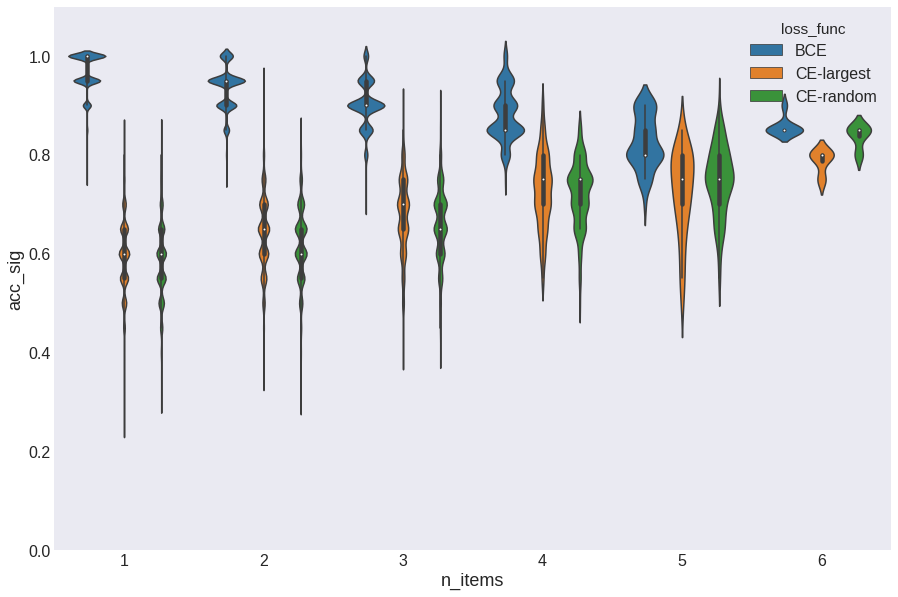

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='n_items', y='acc_sig', hue='loss_func', data=test_df);
ax.set_ylim([0.0, 1.1]);

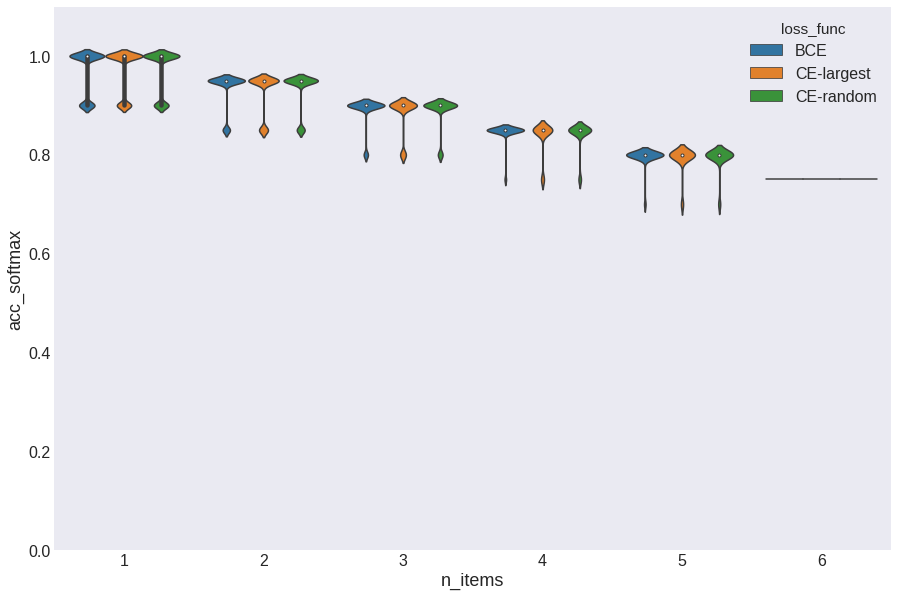

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='n_items', y='acc_softmax', hue='loss_func', data=test_df);
ax.set_ylim([0.0, 1.1]);

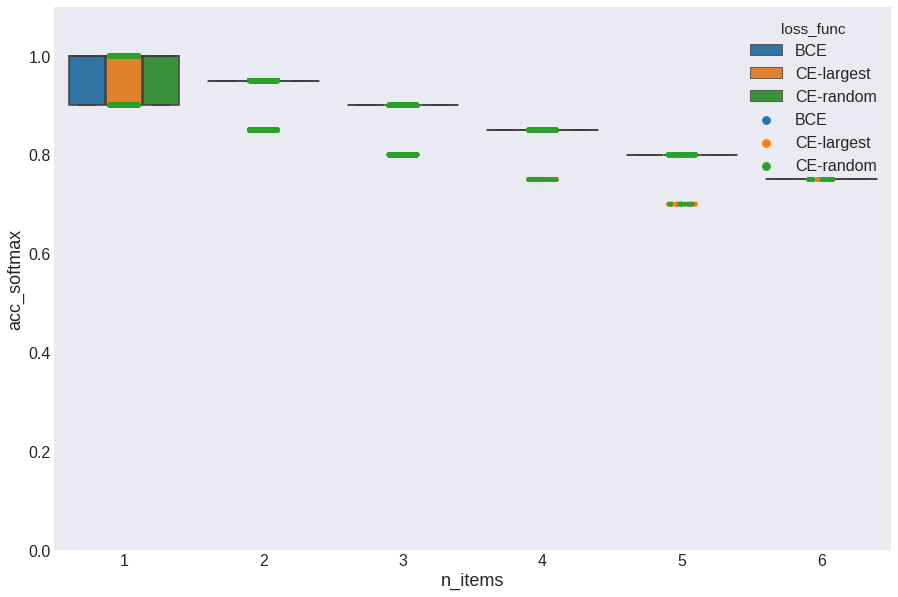

In [97]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='n_items', y='acc_softmax', hue='loss_func', data=test_df, showfliers=False, ax=ax);
sns.stripplot(x='n_items', y='acc_softmax', hue='loss_func', data=test_df);
ax.set_ylim([0.0, 1.1]);

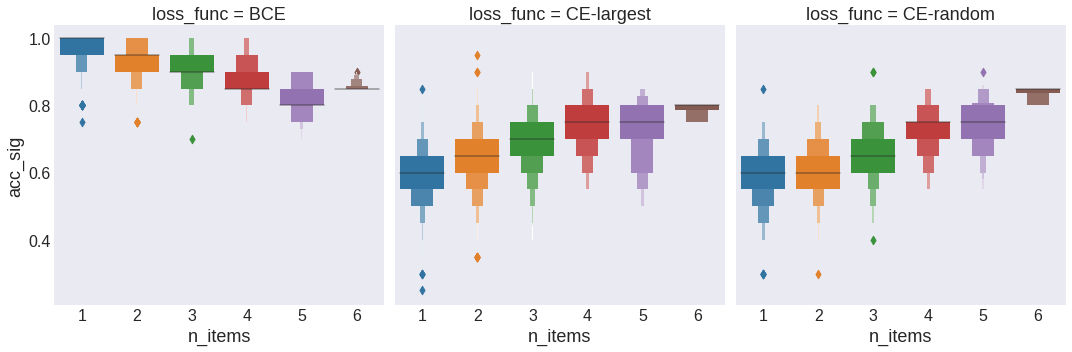

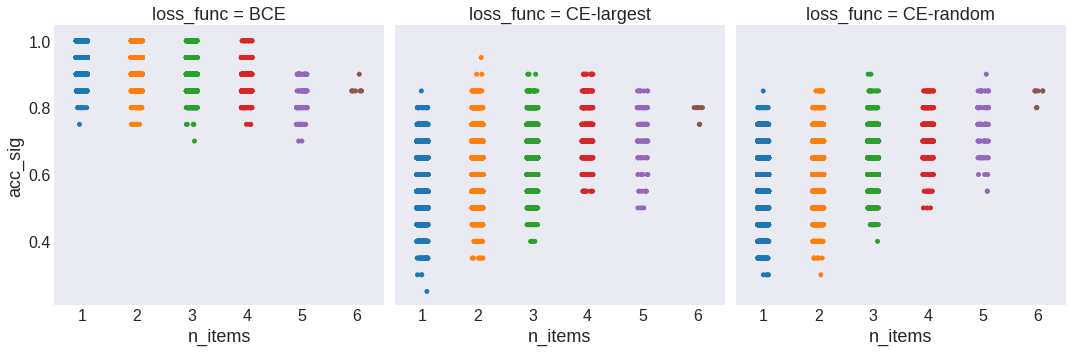

In [104]:
ax = sns.catplot(x='n_items', y='acc_sig', col='loss_func', kind="boxen", data=test_df);
ax = sns.catplot(x='n_items', y='acc_sig', col='loss_func', kind="strip", data=test_df);

In [112]:
test_df["acc_sig"].unique()

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.55, 0.6 , 0.5 , 0.65,
       0.45, 0.4 , 0.35, 0.3 , 0.25])

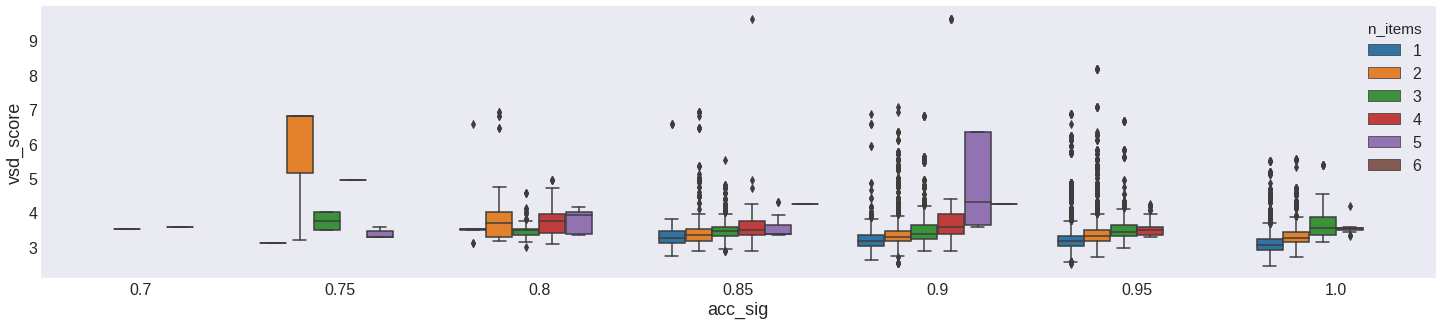

In [146]:
fig, ax = plt.subplots(figsize=(25,5))
sns.boxplot(x="acc_sig", y="vsd_score", hue="n_items", data=test_df[test_df['loss_func'] == 'BCE']);

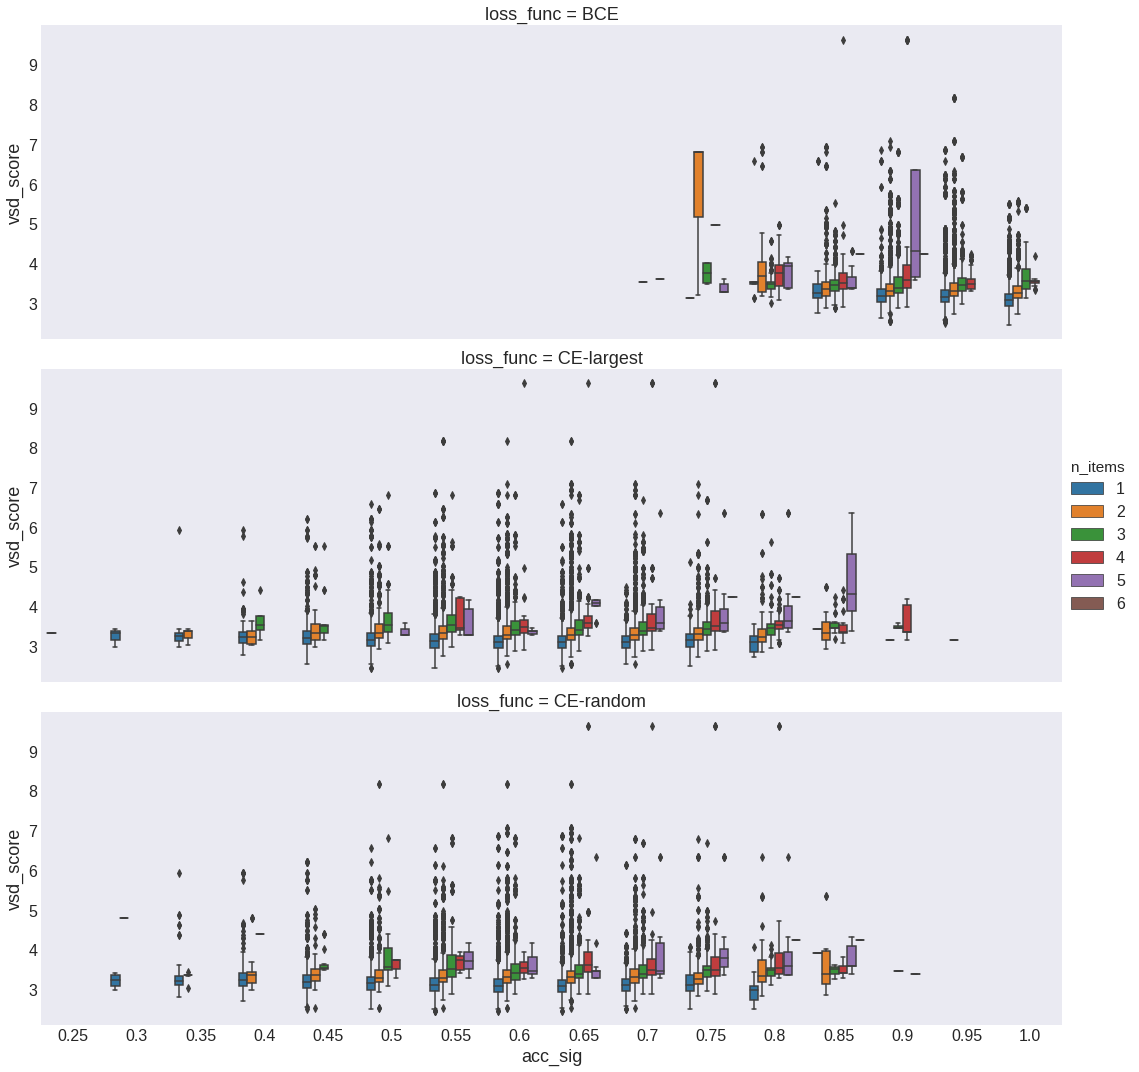

In [130]:
sns.catplot(x="acc_sig", y="vsd_score", row="loss_func", kind="box", hue="n_items", data=test_df, height=5, aspect=3);

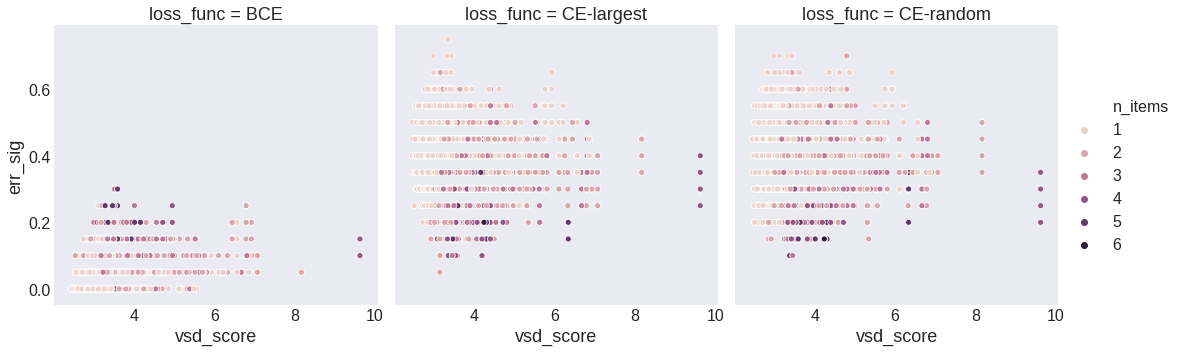

In [157]:
cmap = sns.color_palette("Blues")
ax = sns.relplot(x="vsd_score", y="err_sig", hue="n_items", col="loss_func", legend="full", data=test_df, cmap=cmap);

## is there a relationship between number of items and visual difficulty score

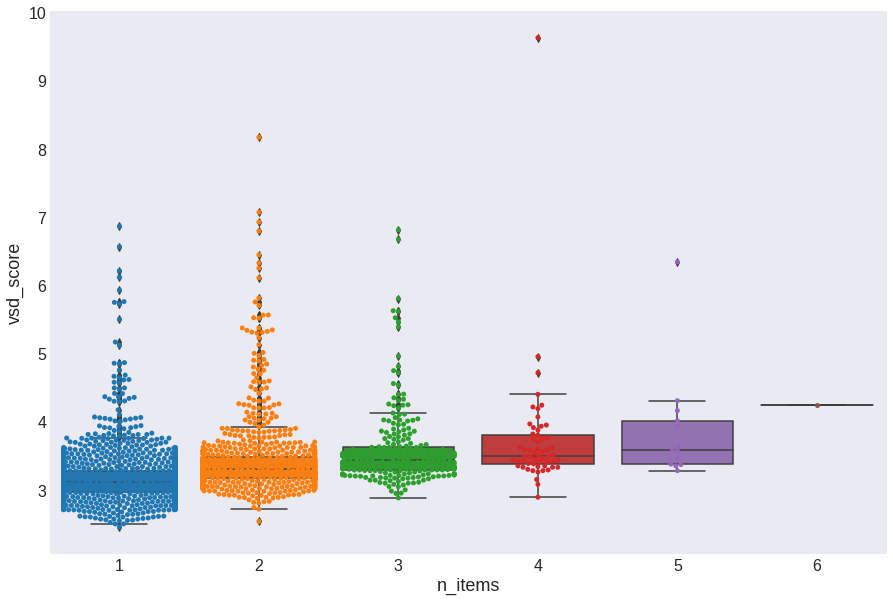

In [77]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x="n_items", y="vsd_score", data=test_df[(test_df['loss_func']=='BCE') & (test_df['replicate']==1)], ax=ax)
sns.swarmplot(x="n_items", y="vsd_score", data=test_df[(test_df['loss_func']=='BCE') & (test_df['replicate']==1)], ax=ax)

box plot + swarm plot suggest that yes, visual difficulty score does increase as the number of items increases.

However it's also clear that there's many more images with just one item, and that the range of VSD scores is quite wide for images with one item.

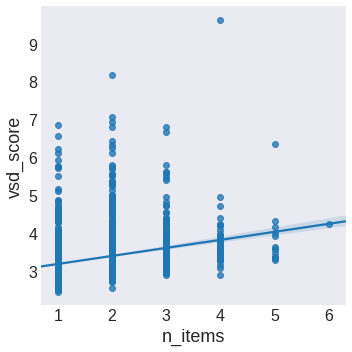

In [80]:
sns.lmplot(x="n_items", y="vsd_score", data=test_df[(test_df['loss_func']=='BCE') & (test_df['replicate']==1)])

In [82]:
Linear regression tells a similar story

SyntaxError: invalid syntax (<ipython-input-82-ebb91187cb23>, line 1)

## Does taking argmax of the softmax output automatically give us 
If we compute accuracy per image, and we can only accurately classify at most one of the classes present, as is the case for classifying by taking the arg max of the soft max output of a network, then there are a fixed number of accuracies for any given image, and 

This is a consequence of how accuracy is computed in this context.  
But to make this point extra clear we can compute unique values for each number of items, and verify it holds true regardless of loss function.

In [90]:
for loss_func in test_df['loss_func'].unique():
    for n_items in sorted(test_df['n_items'].unique()):
        softmax_acc_vals = data=test_df[(test_df['loss_func']==loss_func) & (test_df['n_items']==n_items)]['acc_softmax'].values
        uniq_softmax_acc, counts = np.unique(softmax_acc_vals, return_counts=True)
        print(
            f'unique values for softmax accuracy on image with {n_items} items when trained with {loss_func} loss function:]\n'
            f'{uniq_softmax_acc}.\nCounts: {counts}'
        )

unique values for softmax accuracy on image with 1 items when trained with BCE loss function:]
[0.9 1. ].
Counts: [4280 9672]
unique values for softmax accuracy on image with 2 items when trained with BCE loss function:]
[0.85 0.95].
Counts: [1078 5498]
unique values for softmax accuracy on image with 3 items when trained with BCE loss function:]
[0.8 0.9].
Counts: [ 203 1773]
unique values for softmax accuracy on image with 4 items when trained with BCE loss function:]
[0.75 0.85].
Counts: [ 18 438]
unique values for softmax accuracy on image with 5 items when trained with BCE loss function:]
[0.7 0.8].
Counts: [  4 100]
unique values for softmax accuracy on image with 6 items when trained with BCE loss function:]
[0.75].
Counts: [8]
unique values for softmax accuracy on image with 1 items when trained with CE-largest loss function:]
[0.9 1. ].
Counts: [ 3875 10077]
unique values for softmax accuracy on image with 2 items when trained with CE-largest loss function:]
[0.85 0.95].
Count

What about when we take a threshold on the sigmoid activation?

In [91]:
for loss_func in test_df['loss_func'].unique():
    for n_items in sorted(test_df['n_items'].unique()):
        softmax_acc_vals = data=test_df[(test_df['loss_func']==loss_func) & (test_df['n_items']==n_items)]['acc_sig'].values
        uniq_softmax_acc, counts = np.unique(softmax_acc_vals, return_counts=True)
        print(
            f'unique values for sigmoid accuracy on image with {n_items} items when trained with {loss_func} loss function:]\n'
            f'{uniq_softmax_acc}.\nCounts: {counts}'
        )

unique values for sigmoid accuracy on image with 1 items when trained with BCE loss function:]
[0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [   1   11  184 1514 5120 7122]
unique values for sigmoid accuracy on image with 2 items when trained with BCE loss function:]
[0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [   7   42  467 1728 3211 1121]
unique values for sigmoid accuracy on image with 3 items when trained with BCE loss function:]
[0.7  0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [  1   4  80 358 980 433 120]
unique values for sigmoid accuracy on image with 4 items when trained with BCE loss function:]
[0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [  3  45 187 118  86  17]
unique values for sigmoid accuracy on image with 5 items when trained with BCE loss function:]
[0.7  0.75 0.8  0.85 0.9 ].
Counts: [ 2 15 41 21 25]
unique values for sigmoid accuracy on image with 6 items when trained with BCE loss function:]
[0.85 0.9 ].
Counts: [7 1]
unique values for sigmoid accuracy on image with 1 items when